[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/bayes_course_2023/blob/master/notebooks/Section1_4-Model-Building-with-PyMC.ipynb)

# Building Models in PyMC

Now that we have been introduced to PyMC and Pytensor at a very high level, let's now take a more detailed look at PyMC's API as it relates to building models.

Bayesian inference begins with specification of a probability model relating unknown variables to data. PyMC provides the basic building blocks for Bayesian probability models: stochastic random variables, deterministic variables, and factor potentials. 

A **stochastic random variable** is a factor whose value is not completely determined by its parents, while the value of a **deterministic random variable** is entirely determined by its parents. Most models can be constructed using only these two variable types. The third quantity, the **factor potential**, is *not* a variable but simply a
log-likelihood term or constraint that is added to the joint log-probability to modify it. 

## The Distribution class

A stochastic variable is represented in PyMC by a `Distribution` class. This structure adds functionality to Pytensor's `pytensor.tensor.random.op.RandomVariable` class, mainly by registering it with an associated PyMC `Model`. As we demonstrated in a previous section, `Distribution` objects are only usable inside of a `Model` context.

`Distribution` subclasses (i.e. implementations of specific statistical distributions) will accept several arguments when constructed:

`name`
:   Name for the new model variable. This argument is **required**, and is used as a label and index value for the variable.

`shape`
:   The variable's shape.

`total_size`
:   The overall size of the variable (this variable will not exist for scalars).

`dims`
:   A tuple of dimension names known to the model.

`transform`
:   A transformation to be applied to the distribution when used by the model, especially when the distribution is constrained.

`initval`
:   Numeric or symbolic untransformed initial value of matching shape, or one of the following initial value strategies: "moment", "prior". Depending on the sampler's settings, a random jitter may be added to numeric, symbolic or moment-based initial values in the transformed space.

`model`
:   The PyMC model to which the variable belongs.


As we previewed in the introduction, `Distribution` has a classmethod `dist` that returns a **stateless** probability distribution of that type; that is, without being wrapped in a PyMC random variable object. Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. 

In [ ]:
import seaborn as sns
import pymc as pm
import arviz as az

x = pm.Exponential.dist(1)
samples = pm.draw(x, draws=1000)
sns.histplot(samples);

## Motivating Example: Educational Outcomes for Hearing-impaired Children

To demonstrate the PyMC API in-depth, we will use a dataset of educational outcomes for children with hearing impairment. Here, we are interested in determining factors that are associated with better or poorer learning outcomes. 

This anonomized dataset is taken from the Listening and Spoken Language Data Repository (LSL-DR), an international data repository that tracks the demographics and longitudinal outcomes for children who have hearing loss and are enrolled programs focused on supporting listening and spoken language development. Researchers are interesting in discovering factors related to improvements in educational outcomes at within these programs.

There is a suite of available predictors, including: 

* gender (`male`)
* number of siblings in the household (`siblings`)
* index of family involvement (`family_inv`)
* whether the primary household language is not English (`non_english`)
* presence of a previous disability (`prev_disab`)
* non-white race (`non_white`)
* age at the time of testing (in months, `age_test`)
* whether hearing loss is not severe (`non_severe_hl`)
* whether the subject's mother obtained a high school diploma or better (`mother_hs`)
* whether the hearing impairment was identified by 3 months of age (`early_ident`).

The outcome variable is a standardized test score in one of several learning domains.

In [ ]:
import pandas as pd

test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

In [ ]:
test_scores["score"].hist();

In [ ]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

### The Model

This is a **multivariate regression** model, which takes the form:

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \beta_0 + X \beta
\end{aligned}$$

where $X$ is a matrix of predictors and $\beta$ a vector of coefficients.

However, while there are several potential predictors in the LSL-DR dataset, it is difficult *a priori* to determine which ones are relevant for constructing an effective statistical model. There are a number of approaches for conducting variable selection, but a popular automated method is *regularization*, whereby ineffective covariates are shrunk towards zero via regularization (a form of penalization) if they do not contribute to predicting outcomes. 

You may have heard of regularization from machine learning or classical statistics applications, where methods like the lasso or ridge regression shrink parameters towards zero by applying a penalty to the size of the regression parameters. In a Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the *hierarchical regularized horseshoe*, which uses two regularization strategies, one global and a set of local local parameters, one for each coefficient. The key to making this work is by selecting a long-tailed distribution as the shrinkage priors, which allows some to be nonzero, while pushing the rest towards zero.

The horeshoe prior for each regression coefficient $\beta_i$ looks like this:

$$\beta_i \sim N\left(0, \tau^2 \cdot \tilde{\lambda}_i^2\right)$$

where $\sigma$ is the prior on the error standard deviation that will also be used for the model likelihood.

Where $\tau$ is the global shrinkage parameter and $\tilde{\lambda}_i$ is the local. Let's start global: for the prior on $\tau$ we will use a Half-StudentT distribution, which is a reasonable choice becuase it is heavy-tailed.

$$
\tau \sim \textrm{Half-StudentT}_{2} \left(\frac{D_0}{D - D_0} \cdot \frac{\sigma}{\sqrt{N}}\right).
$$

One catch is that the parameterization of the prior requires a pre-specified value $D_0$, which represents the true number of non-zero coefficients. Fortunately, a reasonable guess at this value is all that is required, and it need only be within an order of magnitude of the true number. Let's use half the number of predictors as our guess:

In [ ]:
D0 = int(D / 2)
D0

Meanwhile, the local shrinkage parameters are defined by the ratio:

$$\tilde{\lambda}_i^2 = \frac{c^2 \lambda_i^2}{c^2 + \tau^2 \lambda_i^2}.$$

To complete this specification, we need priors on $\lambda_i$ and $c$;  as with the global shrinkage, we use a long-tailed $\textrm{Half-StudentT}_5(1)$  on the $\lambda_i$. We need $c^2$ to be strictly positive, but not necessarily long-tailed, so an inverse gamma prior on $c^2$, $c^2 \sim \textrm{InverseGamma}(1, 1)$ fits the bill.


### Creation of stochastic random variables

Stochastic random variables with standard distributions provided by PyMC can be created in a single line using special subclasses of the `Distribution` class. 

This model employs a couple of new distributions: the `HalfStudentT` distribution for the $\tau$ and $\lambda$ priors, and the `InverseGamma` distribution for the $c2$ variable.

We are also going to take advantage of **named dimensions** in PyMC by passing the input variable names into the model as coordinates called "predictors". This will allow us to pass this vector of names as a replacement for the `shape` integer argument in the vector-valued parameters. The model will then associate the appropriate name with each latent parameter that it is estimating. This is a little more work to set up, but will pay dividends later when we are working with our model output.

In [ ]:
import pymc as pm
import numpy as np

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:

    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)
    
    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 2, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 0.1)

## Model Contexts and Random Variables

As we have seen, the canonical way to specify PyMC models is using a `Model` context manager. Generally speaking, a context manager is a Python idiom that does the following:

```python
    VAR = EXPR
    VAR.__enter__()
    try:
        USERCODE
    finally:
        VAR.__exit__()

```

As an analogy, `Model` is a tape machine that records what is being added to the model; it keeps track the random variables (observed or unobserved) and other model components. The model context then computes some simple model properties, builds a **bijection** mapping that transforms between Python dictionaries and numpy/Pytensor ndarrays. , More importantly, a `Model` contains methods to compile Pytensor functions that take Random Variables--that are also
initialised within the same model--as input.

Within a model context, random variables are essentially Pytensor `TensorVariables`:

```python
with pm.Model() as model:
    z = pm.Normal('z', mu=0., sigma=5.)             # ==> pytensor.tensor.var.TensorVariable
    x = pm.Normal('x', mu=z, sigma=1., observed=5.) # ==> pytensor.tensor.var.TensorVariable
pm.logp(z, 2.5).eval()                              # ==> -2.65337645
model.compile_logp()({'z': 2.5})                    # ==> -6.6973152

```

PyMC includes most of the probability density functions (for continuous variables) and probability mass functions (for discrete variables) used in statistical modeling. These distributions are divided into five distinct categories:

* Univariate continuous
* Univariate discrete
* Multivariate
* Mixture
* Timeseries

Probability distributions are all subclasses of `Distribution`, which in turn has two major subclasses: `Discrete` and `Continuous`. In terms of data types, a `Continuous` random variable is given whichever floating point type is defined by `pytensor.config.floatX`, while `Discrete` variables are given `int16` types when `pytensor.config.floatX` is `float32`, and `int64` otherwise.

In [ ]:
sigma.dtype

Multivariate and Timeseries random variables are vector-valued, rather than scalar (though `Continuous` and `Discrete` variables may have non-scalar values).

In [ ]:
sigma.shape.eval()

In [ ]:
lam.shape.eval()

All of the `Distribution` subclasses included in PyMC will have two key methods, `random()` and `logp()`, which are used to generate random values and compute the log-probability of a value, respectively.

```python
class SomeDistribution(Continuous):
    def __init__(...):
        ...

    def random(self, point=None, size=None):
        ...
        return random_samples

    def logp(self, value):
        ...
        return total_log_prob
```

PyMC expects the `logp()` method to return a log-probability evaluated at the passed `value` argument. This method is used internally by all of the inference methods to calculate the model log-probability that is used for fitting models. The `random()` method is used to simulate values from the variable, and is used internally for posterior predictive checks.

Distributions will optionally have `cdf` and `icdf` methods, representing the cumulative distribution function and inverse cumulative distribution functions, respectively.

If you have a well-behaved density function, we can use it in a model to build a model log-likelihood function. Almost any Pytensor function can be turned into a
distribution using the `DensityDist` function. For exmaple, a uniformly-distributed discrete stochastic variable could be created manually from a function that computes its log-probability as follows:

In [ ]:
with pm.Model():
    
    def uniform_logp(value, lower, upper):
        return pm.math.switch((value > upper) | (value < lower), -np.inf, -pm.math.log(upper - lower + 1))

    u = pm.DensityDist('u', 0, 10, logp=uniform_logp, dtype='int64')

In [ ]:
pm.logp(u, 2).eval()

Passing values outside the support of the distribution to `logp()` will return `-inf`, since the value has no probability. 

In [ ]:
pm.logp(u, -4).eval()

A couple of things to notice: while the function specified for the `logp` argument can be an arbitrary Python function, it must use **Pytensor operators and functions** in its body. This is because one or more of the arguments passed to the function may be `TensorVariables`, and they must be supported. 

To emphasize, the Python function passed to `DensityDist` should compute the *log*-density or *log*-probability of the variable. That is why the return value in the example above is `-log(upper-lower+1)` rather than `1/(upper-lower+1)`.

### Auto-transformation

To support efficient sampling by PyMC's MCMC algorithms, any continuous variables that are constrained to a sub-interval of the real line are automatically transformed so that their support is unconstrained. This frees sampling algorithms from having to deal with boundary constraints.

For example, if we look at the variables we have create in the test score model so far:

In [ ]:
test_score_model.value_vars

The model's `value_vars` attribute stores the values of each random variable actually used by the model's log-likelihood.

As the name suggests, the variables `sigma`, `tau`, `lam`, and `c2` have been log-transformed, and this is the space over which posterior sampling takes place. When a sample is drawn, the value of the transformed variable is simply back-transformed to recover the original variable.

By default, auto-transformed variables are ignored when summarizing and plotting model output, since they are not generally of interest to the user.

Returning to our model specification, the intercept will not be subject to regularization, and will be given a normal distribution centered on the population mean:

In [ ]:
with test_score_model:
    beta0 = pm.Normal("beta0", 100, 25.0)

## Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents.

In [ ]:
with test_score_model:

    shrinkage_sd = tau * lam * pm.math.sqrt(c2 / (c2 + tau**2 * lam**2))

    beta = pm.Normal('beta', 0, shrinkage_sd, dims='predictors')

so `shrinkage_sd`'s value can be computed exactly from the values of its parents `tau`, `lam` and `c2`.

There are two types of deterministic variables in PyMC:

#### Anonymous deterministic variables

The easiest way to create a deterministic variable is to operate on or transform one or more variables in a model directly, as we have done above for `shrinkage_sd`.

These are called *anonymous* variables because we did not wrap it with a call to `Determinstic`, which gives it a name as its first argument. We simply specified the variable as a Python (or, Pytensor) expression. This is therefore the simplest way to construct a determinstic variable. The only caveat is that the values generated by anonymous determinstics at every iteration of a MCMC algorithm, for example, are not recorded to the resulting trace. So, this approach is only appropriate for intermediate values in your model that you do not wish to obtain posterior estimates for, alongside the other variables in the model.

#### Named deterministic variables

To ensure that deterministic variables' values are accumulated during sampling, they should be instantiated using the **named deterministic** interface; this uses the `Deterministic` function to create the variable. Two things happen when a variable is created this way:

1. The variable is given a name (passed as the first argument)
2. The variable is appended to the model's list of random variables, which ensures that its values are tallied.

If we wanted named variabels for the shrinkage standard deviation, we would have specified:

```python
shrinkage_sd = pm.Deterministic('shrinkage_sd', tau * lam * pm.math.sqrt(c2 / (c2 + tau**2 * lam**2)))
```

## Observed Random Variables

Stochastic random variables whose values are observed (*i.e.* data likelihoods) are represented by a different class than unobserved random variables. A `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. 

In [ ]:
with test_score_model:
    
    scores = pm.Normal("scores", beta0 + X.values @ beta, sigma, observed=y.values)

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, when they are present (absent?). More on this later.

## Factor Potentials

For some applications, we want to be able to modify the joint density by incorporating terms that don't correspond to probabilities of variables conditional on parents. For example, suppose in the coal mining disasters model we want to constrain the difference between the early and late means to be less than 1, so that the joint density becomes: 

$$p(y,\tau,\lambda_1,\lambda_2) \propto p(y|\tau,\lambda_1,\lambda_2) p(\tau) p(\lambda_1) p(\lambda_2) I(|\lambda_2-\lambda_1| \lt 1)$$

We call such log-probability terms **factor potentials** (Jordan 2004). Bayesian
hierarchical notation doesn't accomodate these potentials. 

### Creation of Potentials

A potential can be created via the `Potential` function, in a way very similar to `Deterministic`'s named interface:

```python
with disaster_model:
    
    rate_constraint = pm.Potential('rate_constraint', pm.math.switch(pm.math.abs(early_mean-late_mean)>1, -np.inf, 0))
```

The function takes just a `name` as its first argument and an expression returning the appropriate log-probability as the second argument.

A common use of a factor potential is to represent an observed likelihood, where the **observations are partly a function of model variables**. In the contrived example below, we are representing the error in a linear regression model as a zero-mean normal random variable. Thus, the "data" in this scenario is the residual, which is a function both of the data and the regression parameters. 

If we represent this as a standard likelihood function (a `Distribution` with an `observed` keyword argument), we run into problems. This parameterization would not be compatible with an observed stochastic, because the `err` term would become fixed in the likelihood and not be allowed to change during sampling.

In [ ]:
y = np.array([15, 10, 16, 11, 9, 11, 10, 18, 11])
x = np.array([1, 2, 4, 5, 6, 8, 19, 18, 12])

with pm.Model() as regression:

    sigma = pm.HalfCauchy('sigma', 5)
    beta = pm.Normal('beta', 0, sigma=2)
    mu = pm.Normal('mu', 0, sigma=10)

    err = y - (mu + beta*x)
                  
    like = pm.Normal('like', 0, sigma=sigma, observed=err)

Instead, we can re-express the likelihood as a factor potential, which is a function of the data and the model parameters. 

In [ ]:
y = np.array([15, 10, 16, 11, 9, 11, 10, 18, 11])
x = np.array([1, 2, 4, 5, 6, 8, 19, 18, 12])

with pm.Model() as regression:

    sigma = pm.HalfCauchy('sigma', 5)
    beta = pm.Normal('beta', 0, sigma=2)
    mu = pm.Normal('mu', 0, sigma=10)

    err = y - (mu + beta*x)
                  
    like = pm.Potential('like', 
        pm.logp(
            pm.Normal.dist(0, sigma=sigma), 
            err
        )
    )

## Exercise: Bioassay model

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to 5 rats during the experiment. The response variable is death, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
y_i &\sim \text{Bin}(n_i, p_i) \\
\text{logit}(p_i) &= a + b x_i
\end{aligned}$$

The common statistic of interest in such experiments is the LD50, the dosage at which the probability of death is 50%.

Specify this model in PyMC:

In [ ]:
# Log dose in each group
log_dose = [-.86, -.3, -.05, .73]

# Sample size in each group
n = 5

# Outcomes
deaths = [0, 1, 3, 5]

In [ ]:
# Write answer here

## Sampling with MCMC

PyMC's core business is using Markov chain Monte Carlo to fit virtually any probability model. This involves the assignment and coordination of a suite of **step methods**, each of which is responsible for updating one or more variables. 

The user's interface to PyMC's sampling algorithms is the `sample` function:

```python
pm.sample(
    draws: int = 1000,
    *,
    tune: int = 1000,
    chains: Optional[int] = None,
    cores: Optional[int] = None,
    random_seed: Union[int, Sequence[int], numpy.ndarray, NoneType, numpy.random.mtrand.RandomState, numpy.random._generator.Generator] = None,
    progressbar: bool = True,
    step=None,
    nuts_sampler: str = 'pymc',
    initvals: Union[Dict[Union[pytensor.graph.basic.Variable, str], Union[numpy.ndarray, pytensor.graph.basic.Variable, str]], Sequence[Optional[Dict[Union[pytensor.graph.basic.Variable, str], Union[numpy.ndarray, pytensor.graph.basic.Variable, str]]]], NoneType] = None,
    init: str = 'auto',
    jitter_max_retries: int = 10,
    n_init: int = 200000,
    trace: Optional[pymc.backends.base.BaseTrace] = None,
    discard_tuned_samples: bool = True,
    compute_convergence_checks: bool = True,
    keep_warning_stat: bool = False,
    return_inferencedata: bool = True,
    idata_kwargs: Optional[Dict[str, Any]] = None,
    nuts_sampler_kwargs: Optional[Dict[str, Any]] = None,
    callback=None,
    mp_ctx=None,
    model: Optional[pymc.model.Model] = None,
    **kwargs,
)
```

`sample` assigns particular samplers to model variables, and generates samples from them. The `draws` argument
controls the total number of MCMC iterations. PyMC can automate most of the details of sampling, outside of the selection of the number of draws, using default settings for several parameters that control how the sampling is set up and conducted. However, users may manually intervene in the specification of the sampling by passing values to a number of keyword argumetns for `sample`.

### Assigning step methods

The `step` argument allows users to assign a MCMC sampling algorithm to the entire model, or to a subset of the variables in the model. For example, if we wanted to use the Metropolis-Hastings sampler to fit our model, we could pass an instance of that step method to `sample` via the `step` argument:

```python
with my_model:

    trace = pm.sample(1000, step=pm.Metropolis())
```

or if we only wanted to assign `Metropolis` to a parameter called `beta`:

```python
with my_model:

    trace = pm.sample(1000, step=pm.Metropolis(vars=[beta]))
```

Step method classes handle individual stochastic variables, or sometimes groups of them. They are responsible for making the variables they handle take **single MCMC steps** conditional on the rest of the model. Each PyMC step method (usually subclasses of `ArrayStep`) implements a method called `astep()`, which is called iteratively by `sample`. 

All step methods share an optional argument `vars` that allows a particular subset of variables to be handled by the step method instance. Particular step methods will have additional arguments for setting parameters and preferences specific to that sampling algorithm.

> NB: when a PyMC function or method has an argument called `vars` it is expecting a list of variables (*i.e.* the variables themselves), whereas arguments called `var_names` expect a list of variables names (*i.e.* strings)

#### HamiltonianMC

The Hamiltonian Monte Carlo algorithm is implemented in the `HamiltonianMC` class. Being a gradient-based sampler, it is only suitable for **continuous random variables**. Several optional arguments can be provided by the user. The algorithm is **non-adaptive**, so the parameter values passed at instantiation are fixed at those values throughout sampling.

`HamiltonianMC` requires a scaling matrix parameter `scaling`, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although it is used somewhat differently here. The matrix gives an approximate shape of the posterior distribution, so that `HamiltonianMC` does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. 

Fortunately, `HamiltonianMC` can often make good guesses for the scaling parameters. If you pass a point in parameter space (as a dictionary of variable names to parameter values, the same format as returned by `find_MAP`), it will look at the **local curvature** of the log posterior-density (the diagonal of the Hessian matrix) at that point to guess values for a good scaling vector, which can result in a good scaling value. Also, the MAP estimate is often a good point to use to initiate sampling. 

- `scaling` 
: Scaling for momentum distribution. If a 1-dimensional array is passed, it is interpreted as a matrix diagonal.
            
- `step_scale` 
: Size of steps to take, automatically scaled down by $1/n^{0.25}$. Defaults to .25.
            
- `path_length` 
: total length to travel during leapfrog. Defaults to 2.
            
- `is_cov` 
: Flag for treating scaling as a covariance matrix/vector, if True. Treated as precision otherwise.
            
- `step_rand` 
: A function which takes the step size and returns an new one used to randomize the step size at each iteration.


#### NUTS

`NUTS` is the No U-turn Sampler of Hoffman and Gelman (2014), an adaptive version of Hamiltonian MC that **automatically tunes** the step size and number on the fly. 

In addition to the arguments to `HamiltonianMC`, `NUTS` takes additional parameters to controls the tuning. The most important of these is the target acceptance rate for the Metropolis acceptance phase of the algorithm, `target_accept`. 
Sometimes if the NUTS struggles to sample efficiently, changing this parameter above the default target rate of 0.8 will improve sampling (the original recommendation by Hoffman & Gelman was 0.6). Increasing the rate very high will also make the sampler more conservative, however, taking many small steps at every iteration. 

In [ ]:
with test_score_model:
    trace_90 = pm.sample(1000, tune=2000, target_accept=0.9)

In [ ]:
trace_90.sample_stats['acceptance_rate'].mean()

There is rarely a reason to use `HamiltonianMC` rather than `NUTS`. It is the default sampler for continuous variables in PyMC.

### Metropolis

``Metropolis`` implements a Metropolis-Hastings step, as described the theory section, and is designed to handle float- and integer-valued variables.

A `Metropolis` step method can be instantiated with any of several optional arguments:

- `S`
:   This sets the proposal standard deviation or covariance matrix.

- `proposal_dist`
:   A function that generates zero-mean random deviates used as proposals. Defaults to the normal distribution.

- `scaling`
:   An initial scale factor for the proposal

- `tune_interval`
:   The number of intervals between tuning updates to `scaling` factor.

When the step method is instantiated, the `proposal_dist` is parameterized with the value passed for `S`. While sampling, the value of `scaling` is used to scale the value proposed by `proposal_dist`, and this value is tuned throughout the MCMC run. During tuning, the acceptance ratio of the step method is examined, and this scaling factor
is updated accordingly. Tuning only occurs when the acceptance rate is **lower than 20%** or **higher than 50%**; rates between 20-50% are considered optimal for Metropolis-Hastings sampling. The default tuning interval (`tune_interval`) is 100 iterations.

Although tuning will continue throughout the sampling loop, it is important to verify that the
**diminishing tuning** condition of [Roberts and Rosenthal (2007)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.jap/1183667414) is satisfied: the
amount of tuning should decrease to zero, or tuning should become very infrequent.

`Metropolis` handles discrete variable types automatically by rounding the proposed values and casting them to integers.

### BinaryMetropolis

While binary (boolean) variables can be handled by the `Metropolis` step method, sampling will be very inefficient. The `BinaryMetropolis` class is optimized to handle binary variables, by one of only two possible values. The only tuneable parameter is the `scaling` argument, which is used to vary the Bernoulli probability:

    p_jump = 1. - .5 ** self.scaling

This value is compared to pseudo-random numbers generated by the step method, to determine whether a 0 or 1 is proposed.

`BinaryMetropolis` will be automatically selected for random variables that are distributed as Bernoulli, or categorical with only 2 categories.

### Slice

Though the Metropolis-Hastings algorithm is easy to implement for a variety of models, its efficiency is poor. We have seen that it is possible to tune Metropolis samplers, but it would be nice to have a "black-box" method that works for arbitrary continuous distributions, which we may know little about a priori.

The **slice sampler** (Neal 2003) improves upon the Metropolis sampler by being both efficient and easy to program generally. The idea is to first sample from the conditional distribution for $y$ (i.e., $Pr(x)$) given some current value of $x$, which is uniform over the $(0,f(x))$, and conditional on this value for $y$, then sample $x$, which is uniform on $S = {x : y < f (x)}$.

In PyMC, the `Slice` class implements the **univariate** slice sampler. It is suitable for univariate, continuous variables. There is a single user-defined parameter `w`, which sets the width of the initial slice. If not specified, it defaults to a width of 1.

PyMC also includes implementations of stochastic gradient Markov chain Monte Carlo (SGMCMC, Nemeth & Fearnhead 2019) and Multi-Level Delayed Acceptance MCMC (MLDA, Dodwell et al. 2019), which we will not cover here. 

When `step` is not specified by the user, PyMC will assign step methods to variables automatically. To do so, each step method implements a class method called `Competence`. This method returns a value from 0 (incompatible) to 3 (ideal), based on the attributes of the random variable in question. `sample()` assigns the step method that returns the highest competence value to each of its unallocated stochastic random variables. In general:

* Binary variables will be assigned to `BinaryMetropolis` (Metropolis-Hastings for binary values)
* Discrete variables will be assigned to `Metropolis`
* Continuous variables will be assigned to `NUTS` (No U-turn Sampler)

### Starting values

The `initvals` argument allows for the specification of starting values for stochastic random variables in the model. MCMC algorithms begin by initializing all unknown quantities to arbitrary starting values. Though in theory the value can be any value under the support of the distribution describing the random variable, we can make sampling more difficult if an initial value is chosen in the extreme tail of the distribution, for example. If starting values are not passed by the user, default values are chosen from the mean, median or mode of the distribution.

It is sometimes (but not always) useful to initialize a MCMC simulation at the maximum *a posteriori* (MAP) estimate:

In [ ]:
with test_score_model:
    
    posterior_mode = pm.find_MAP()

In [ ]:
posterior_mode

In [ ]:
with test_score_model:
    trace = pm.sample(100, step=pm.Metropolis(), cores=2, initvals=posterior_mode)

If we are sampling more than one Markov chain from our model, it is often recommended to initialize each chain to different starting values, so that lack of convergence can be more easily detected (see *Model Checking* section). 

### Storing samples

Notice in the above call to `sample` that output is assigned to a variable we have called `trace`. 

In [ ]:
trace

This `InferenceData` object is a data structure that stores the samples from an MCMC run as grouped attributes. The data structure itself is an `xarray.Dataset` object, which is a dictionary-like object that stores the samples in a multi-dimensional array.

The xarray components include:

- **Data variables** are the actual values generated from the MCMC draws
- **Dimensions** are the axes on which refer to the data variables
- **Coordinates** are pointers to specific slices or points in the `xarray.Dataset`

### Parallel sampling

Nearly all modern desktop computers have multiple CPU cores, and running multiple MCMC chains is an **embarrasingly parallel** computing task. It is therefore relatively simple to run chains in parallel in PyMC. This is done by setting the `cores` argument in `sample` to some value between 2 and the number of cores on your machine (you can specify more chains than cores, but you will not gain efficiency by doing so). The default value of `cores` is `None`, which will select the number of CPUs on your machine, to a maximum of 4. 

> Keep in mind that some chains might themselves be multithreaded via openmp or BLAS. In those cases it might be faster to set this to 1.

By default, PyMC will run a sample a minimum of 2 and a maximum of `cores` chains. However, the number of chains sampled can be set independently of the number of cores by specifying the `chains` argument.

```python
with test_score_model:
    trace = pm.sample(chains=4, cores=2)
```

Running $n$ iterations with $c$ chains will result in $c \times n$ samples.

Generating several chains is generally recommended because it aids in model checking, allowing statistics such as the potential scale reduction factor ($\hat{R}$) and effective sample size to be calculated.

### Reproducible sampling

A practical drawback of using stochastic sampling methods for statistical inference is that it can be more difficult to reproduce individual results, due to the fact that sampling involves the use of pseudo-random number generation. To aid in reproducibility (and debugging), it can be helpful to set a **random number seed** prior to sampling. The `random_seed` argument can be used to set PyMC's random number generator to a particular seed integer, which results in the same sequence of random numbers each time the seed is set to the same value.

In [ ]:
with test_score_model:
    rtrace = pm.sample(100, cores=2, random_seed=42)

In [ ]:
rtrace.posterior['beta0'].sel(chain=0, draw=slice(0, 5))

Setting the same seed for another run of the same model will generate the same sequence of samples:

In [ ]:
with test_score_model:
    rtrace = pm.sample(100, cores=2, random_seed=42)

rtrace.posterior['beta0'].sel(chain=0, draw=slice(0, 5))

### Example: Coal mining disasters

Let's return to the coal mining disasters example from the previous section. Recall that we are interested in estimating the annyal rate of disasters, where there is thought to be a rate change at some point in the time series.

Here again is the model:

$$
y_t \sim \operatorname{Poisson}(\lambda_t), t=1851, \ldots, 1962 \\
\lambda_t = \left\{ \begin{array}{}\lambda_1 \text{ for } t \leq \tau \\ \lambda_2 \text{ for } t > \tau \end{array}\right. \\
\lambda_j \sim \operatorname{Gamma}(1, 10) \\
\tau \sim \operatorname{DiscreteUniform}(1851, 1962)
$$

And an implementation in PyMC:

In [27]:
disasters_array = np.array(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 
     1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 
     1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 
     0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 
     1, 2, 4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 
     1])
years = np.arange(1851, 1962, dtype=int)

with pm.Model() as model:
    early_lambda = pm.Gamma('early_lambda', 1, 0.1)
    late_lambda = pm.Gamma('late_lambda', 1, 0.1)
    change_point = pm.DiscreteUniform('change_point', 1851, 1962)
    
    lam = pm.Deterministic('lam', pm.math.where(years > change_point, late_lambda, early_lambda))
    pm.Poisson('rate', lam, observed=disasters_array)

Use `pm.sample` to draw 1000 samples, using the default step method assigned by PyMC. Then experiment with different step methods and observe the effect on sampling.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [early_lambda, late_lambda]
CompoundStep
>NUTS: [early_lambda, late_lambda]
>Metropolis: [change_point]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/mate_scharnitzky/miniconda/envs/bayes_course/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'change_point'}>,
        <Axes: title={'center': 'change_point'}>],
       [<Axes: title={'center': 'early_lambda'}>,
        <Axes: title={'center': 'early_lambda'}>],
       [<Axes: title={'center': 'late_lambda'}>,
        <Axes: title={'center': 'late_lambda'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>]],
      dtype=object)

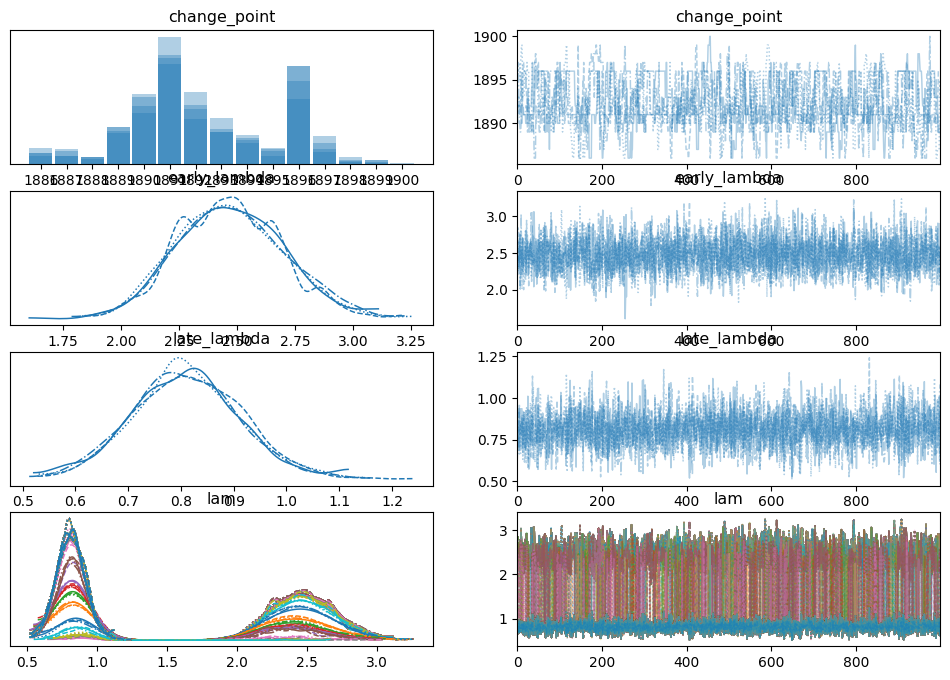

In [31]:
# Write answer here
with model:
    trace = pm.sample(draws=1000, tune=1000)
az.plot_trace(trace)

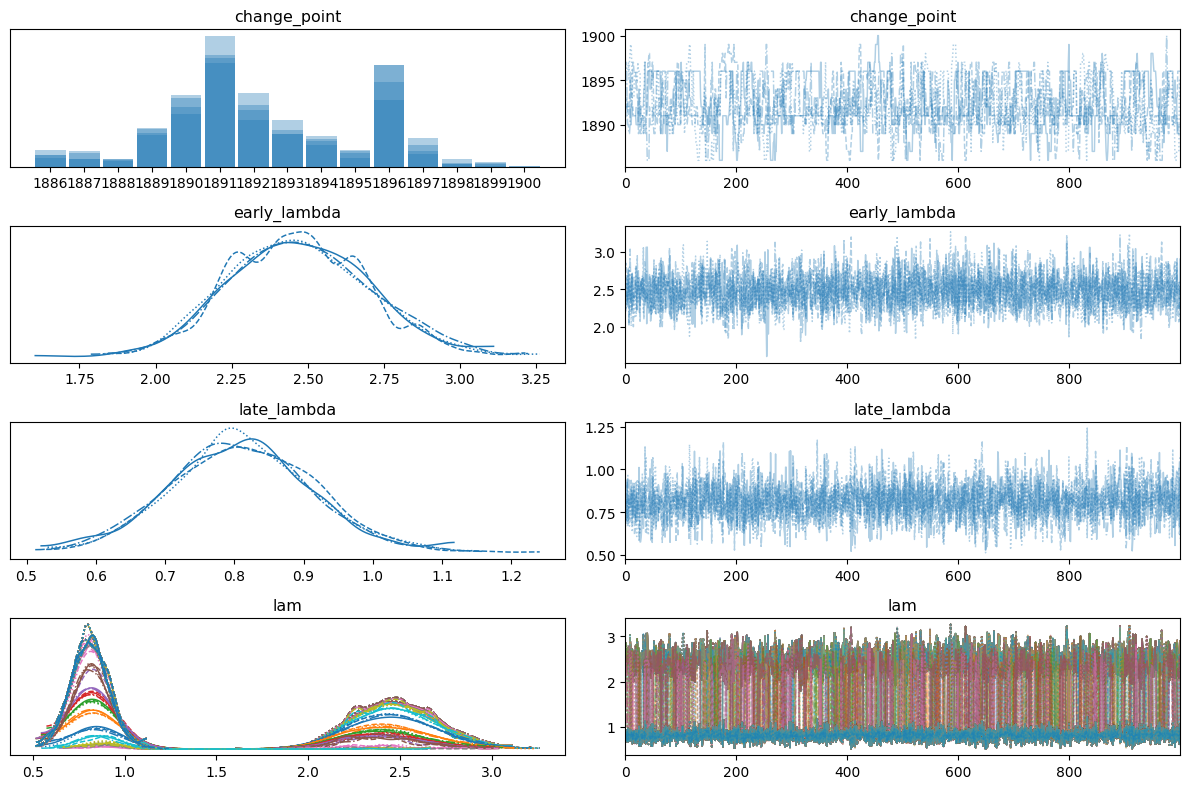

In [35]:
import matplotlib.pyplot as plt
az.plot_trace(trace)
plt.tight_layout()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [early_lambda]
>Metropolis: [late_lambda]
CompoundStep
>Metropolis: [early_lambda]
>Metropolis: [late_lambda]
>Metropolis: [change_point]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.


array([[<Axes: title={'center': 'change_point'}>,
        <Axes: title={'center': 'change_point'}>],
       [<Axes: title={'center': 'early_lambda'}>,
        <Axes: title={'center': 'early_lambda'}>],
       [<Axes: title={'center': 'late_lambda'}>,
        <Axes: title={'center': 'late_lambda'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>]],
      dtype=object)

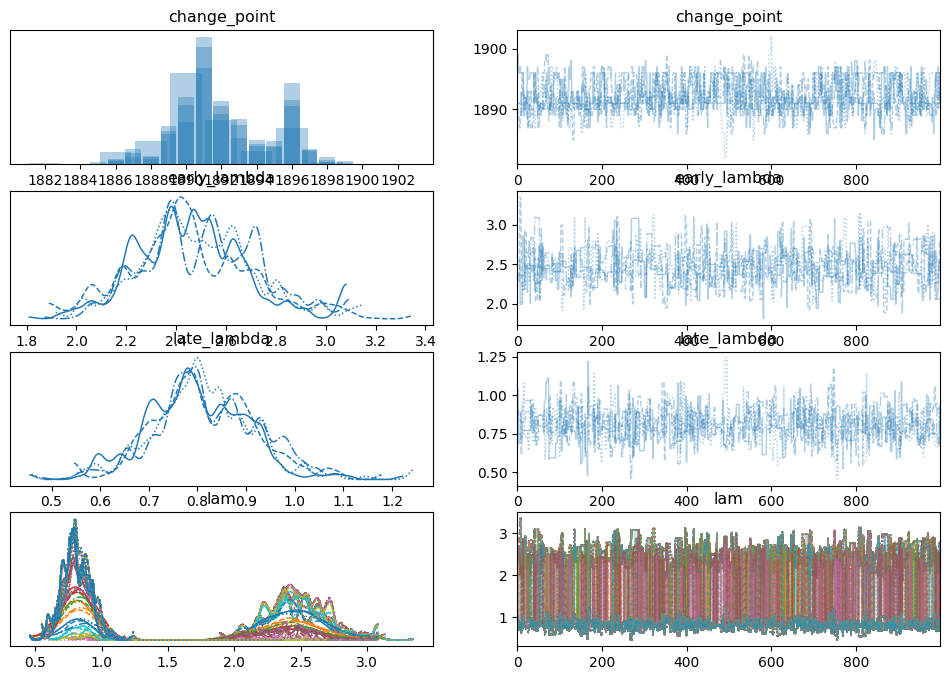

In [32]:
# Write answer here
with model:
    trace_metrop = pm.sample(draws=1000, tune=1000, step=pm.Metropolis())
az.plot_trace(trace_metrop)

In [33]:
# Write answer here
with model:
    trace_slice = pm.sample(draws=1000, tune=1000, step=pm.Slice())
az.plot_trace(trace_slice)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [early_lambda]
>Slice: [late_lambda]
CompoundStep
>Slice: [early_lambda]
>Slice: [late_lambda]
>Slice: [change_point]


ValueError: Not enough samples to build a trace.

## JAX-based Samplers

An alternative to PyMC's PyTensor-based samplers are samplers written in JAX. Using these samplers, all the operations needed to compute a posterior can be performed under JAX, reducing the Python overhead during sampling and leveraging all JAX performance improvements and features like the ability to sample on GPUs or TPUs.

PyMC offers NUTS JAX samplers via [NumPyro](https://num.pyro.ai/en/latest/index.html) or [BlackJAX](https://blackjax-devs.github.io/blackjax/). Significantly, BlackJAX and NumPyro can both be used because in PyMC the modeling language is decoupled from the inference methods; BlackJAX and NumPyro only require a log-probability density function written in JAX. This demonstrates that samplers can be developed independently of PyMC and then be made available to users of the library.

The JAX samplers can be invoked using the `nuts_sampler` argument for `pm.sample`:

```python
pm.sample(nuts_sampler="numpyro")
```

### Exercise: Speed test

Compare the speed of the JAX samplers to the PyTensor samplers using the coal mining disasters model above. 

HINT: You can use the `%%time` magic command to time the execution of a cell.

ANOTHER HINT: You may need to reparameterize the model to use the JAX samplers.

In [36]:
# Write your answer here
with model:
    pymc_trace = pm.sample(nuts_sampler="pymc")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [early_lambda, late_lambda]
>Metropolis: [change_point]
CompoundStep
>NUTS: [early_lambda, late_lambda]
>Metropolis: [change_point]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


## Imputation of Missing Data

As with most textbook examples, the models we have examined so far assume that the associated data are complete. That is, there are no **missing values** corresponding to any observations in the dataset. However, many real-world datasets have missing observations, usually due to some logistical problem during the data collection process. The easiest way of dealing with observations that contain missing values is simply to exclude them from the analysis. However, this results in loss of information if an excluded observation contains valid values for other quantities, and can bias results. An alternative is to impute the missing values, based on information in the rest of the model.

For example, consider a survey dataset for some wildlife species:

    Count   Site   Observer   Temperature
    ------- ------ ---------- -------------
    15      1      1          15
    10      1      2          NA
    6       1      1          11

Each row contains the number of individuals seen during the survey, along with three covariates: the site on which the survey was conducted, the observer that collected the data, and the temperature during the survey. If we are interested in modelling, say, population size as a function of the count and the associated covariates, it is difficult to accommodate the second observation because the temperature is missing (perhaps the thermometer was broken that day). Ignoring this observation will allow us to fit the model, but it wastes information that is contained in the other covariates.

In a Bayesian modelling framework, missing data are accommodated simply by treating them as **unknown model parameters**. Values for the missing data $\tilde{y}$ are estimated naturally, using the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

This describes additional data $\tilde{y}$, which may either be considered unobserved data or potential future observations. We can use the posterior predictive distribution to model the likely values of missing data.

Consider the coal mining disasters data introduced previously. Assume that two years of data are missing from the time series; we indicate this in the data array by the use of an arbitrary placeholder value, `-999`:

In [37]:
disasters_missing = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

N = len(disasters_missing)

To estimate these values in PyMC, we need to convert these placeholder values to `np.nan` (or `None`) values so that they can be handled by the model as missing values:

In [38]:
disasters_missing = np.where(disasters_missing == -999, np.nan, disasters_missing)
disasters_missing

array([ 4.,  5.,  4.,  0.,  1.,  4.,  3.,  4.,  0.,  6.,  3.,  3.,  4.,
        0.,  2.,  6.,  3.,  3.,  5.,  4.,  5.,  3.,  1.,  4.,  4.,  1.,
        5.,  5.,  3.,  4.,  2.,  5.,  2.,  2.,  3.,  4.,  2.,  1.,  3.,
       nan,  2.,  1.,  1.,  1.,  1.,  3.,  0.,  0.,  1.,  0.,  1.,  1.,
        0.,  0.,  3.,  1.,  0.,  3.,  2.,  2.,  0.,  1.,  1.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  1.,
        0.,  2.,  3.,  3.,  1., nan,  2.,  1.,  1.,  1.,  1.,  2.,  4.,
        2.,  0.,  0.,  1.,  4.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  1.])

This array can then be passed to the model likelihood, which recognizes the `nan` values as missing and replaces them with stochastic variables of the desired type. For the coal mining disasters problem, recall that disaster events were modeled as Poisson variates:

```python
disasters = Poisson('disasters', mu=rate, observed=disasters_missing)
```

Each element in `disasters` is a Poisson random variable, irrespective of whether the observation was missing or not. The difference is that actual observations are assumed to be data stochastics, while the missing
values are unobserved stochastics. The latter are considered unknown, rather than fixed, and therefore estimated by the fitting algorithm, just as unknown model parameters are.

The model is otherwise unchanged from the complete data case.

In [41]:
with pm.Model() as missing_data_model:

    # Prior for distribution of switchpoint location
    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=N)
    # Priors for pre- and post-switch mean number of disasters
    early_mean = pm.Exponential('early_mean', lam=1.)
    late_mean = pm.Exponential('late_mean', lam=1.)

    # Allocate appropriate Poisson rates to years before and after current
    # switchpoint location
    idx = np.arange(N)
    rate = pm.math.switch(switchpoint >= idx, early_mean, late_mean)

    # Data likelihood
    disasters = pm.Poisson('disasters', rate, observed=disasters_missing)

/Users/mate_scharnitzky/miniconda/envs/bayes_course/lib/python3.11/site-packages/pymc/model.py:1384: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/Users/mate_scharnitzky/miniconda/envs/bayes_course/lib/python3.11/site-packages/pymc/model.py:1407: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [42]:
with missing_data_model:
    trace_missing = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_missing]
>NUTS: [early_mean, late_mean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
missing_data_model.vars

In [ ]:
import arviz as az

az.summary(trace_missing, var_names=['disasters_missing'])

### Exercise

Load the titanic dataset, and construct an appropriate model to predict passenger survival rate. Summarize the parameter estimates.

In [ ]:
DATA_URL = 'https://raw.githubusercontent.com/fonnesbeck/bayes_course_2022/master/data/'

try:
    titanic = pd.read_excel('../data/titanic.xls')
except FileNotFoundError:
    titanic = pd.read_excel(DATA_URL + 'titanic.xls')
titanic.head()

In [ ]:
# Write answer here

---

## References

1. Ching & Chen. 2007. Transitional Markov chain Monte Carlo method for Bayesian model updating, model class selection and model averaging. Journal of Engineering Mechanics 2007
2.	Hoffman MD, Gelman A. 2014. The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research. 15(1):1593-1623.
3. M.I. Jordan. 2004. Graphical models. Statist. Sci., 19(1):140–155.
4. Neal, R. M. 2003. Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198